# Примерный план:

<pre>Шаг 1. Загрузка данных
Шаг 2. EDA
      2.1 Распределение таргета
      2.2 Распределение фиччей
      2.3 Графики влияния фичей на таргет
Шаг 3. Обработка пропусков
Шаг 4. Разбиение на train / test
Шаг 5. Построение моделей
      5.1 Linear Regression
      5.2 Decision tree
      5.3 Random Forest
      5.4 Gradient Boosting decision trees
Шаг 6. Настройка и оценка финальной модели
Шаг 7. Анализ прогнозов
Шаг 8. Сохранение модели</pre>

### Импорт модулей + функции

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime
import random

import warnings

warnings.filterwarnings('ignore')

In [2]:
TRAIN_DATASET_PATH = "train.csv"
TEST_DATASET_PATH = "test.csv"

In [48]:
SAMPLES_PATH = "sample_submission.csv"

Некоторые графики дико лагают в svg варианте, поэтому такие строю в png

In [3]:
%config InlineBackend.figure_format = 'svg'

In [4]:
%config InlineBackend.figure_format = 'png'

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [59]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### File descriptions

<pre>train.csv - the training set
test.csv - the test set
sampleSubmission.csv - a sample submission file in the correct format</pre>

### Data fields

<pre>Id - идентификационный номер квартиры
DistrictId - идентификационный номер района
Rooms - количество комнат
Square - площадь
LifeSquare - жилая площадь
KitchenSquare - площадь кухни
Floor - этаж
HouseFloor - количество этажей в доме
HouseYear - год постройки дома
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
Social_1, Social_2, Social_3 - социальные показатели местности
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
Price - цена квартиры</pre>

# Шаг 1. Загрузка данных

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [7]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [8]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [9]:
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.3%


# Шаг 2. EDA
## 2.1 Распределение таргета

In [10]:
price = train_df['Price'].to_numpy()
price_median = np.quantile(price, q=0.5)
price_mean = np.mean(price)
price_mode = stats.mode(price)[0][0]
print(f'median - {price_median}\nmean - {price_mean}\nmode - {price_mode}')

median - 192269.6484375
mean - 214138.859375
mode - 182938.078125


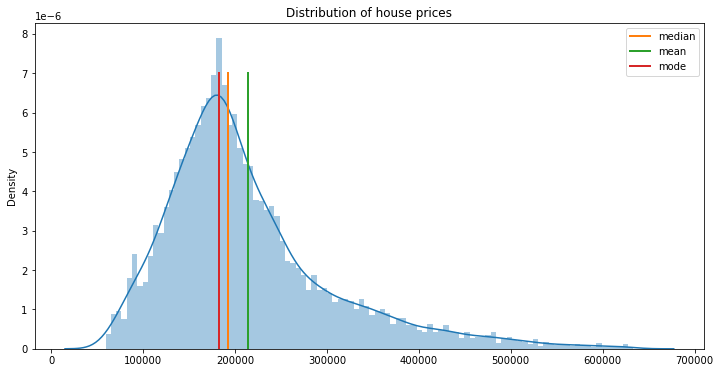

In [11]:
plt.figure(figsize = (12, 6))

sns.distplot(price, bins=100)

y = np.linspace(0, 0.000007, 10)
plt.plot([price_median] * 10, y, label='median', linewidth=2)
plt.plot([price_mean] * 10, y, label='mean', linewidth=2)
plt.plot([price_mode] * 10, y, label='mode', linewidth=2)

plt.title('Distribution of house prices')
plt.legend()
plt.show()

## 2.2 Чистка выбросов и распределение фичей

In [12]:
train_df.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

In [13]:
train_df['HouseYear'].loc[train_df['HouseYear'] > 2020] = train_df['HouseYear'].median()
train_df['LifeSquare'].loc[train_df['LifeSquare'] > 200] = train_df['LifeSquare'].median()
train_df['KitchenSquare'].loc[train_df['KitchenSquare'] > 20] = train_df['KitchenSquare'].median()
train_df['Rooms'].loc[train_df['Rooms'] > 5] = train_df['Rooms'].median()
train_df['HouseFloor'].loc[train_df['HouseFloor'] > 25] = train_df['HouseFloor'].median()
train_df['Square'].loc[train_df['Square'] > 200] = train_df['Square'].median()

In [14]:
features_df = train_df.select_dtypes(include=['float64', 'float32', 'float16', 'int32', 'int16', 'int8'])
features_df.drop('Price', axis=1, inplace=True)
features_df.drop('Id', axis=1, inplace=True)

features_df.head(20)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
0,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,NaN,0,11
1,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16
2,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3
3,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,23,5735,3,1084.0,0,5
4,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,35,5776,1,2078.0,2,4
5,59,3.0,80.384476,46.683720,12.0,5,17.0,2011,0.309479,35,7715,4,990.0,0,6
6,154,2.0,62.254112,37.160378,7.0,3,5.0,1960,0.460556,20,4386,14,NaN,1,5
7,74,2.0,80.312927,NaN,0.0,14,0.0,1977,0.075779,6,1437,3,NaN,0,2
8,1,2.0,64.511436,NaN,1.0,9,17.0,1977,0.007122,1,264,0,NaN,0,1
9,23,1.0,46.461411,18.915552,8.0,13,17.0,2014,0.075779,6,1437,3,NaN,0,2


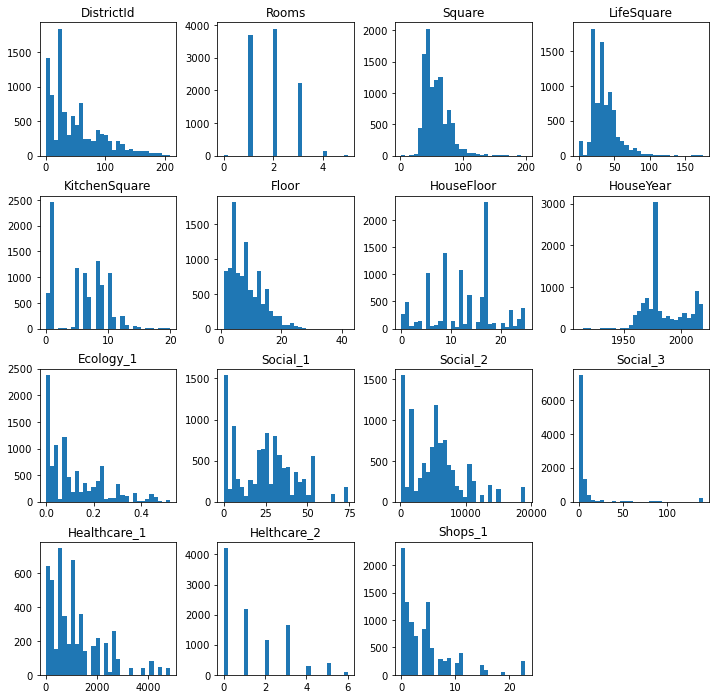

In [15]:
features_df.hist(figsize=(12, 12), bins=30, grid=False);

## 2.3 Графики влияния фичей на таргет

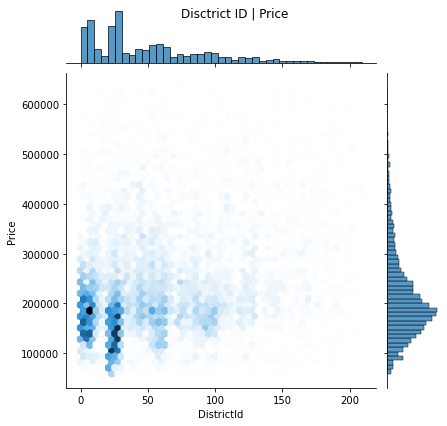

In [16]:
district_price = sns.jointplot(train_df['DistrictId'], train_df['Price'], kind='hex')
district_price.fig.set_figwidth(6)
district_price.fig.set_figheight(6)

plt.xlabel("Disctrict ID")
plt.ylabel("Price")
plt.suptitle('Disctrict ID | Price')

plt.show()

Есть предположение, что чем больше айди района - тем новее район. Большинство домов находится в более старых районах, если следовать этой логике. И если брать в расчет неравное кол-во домов в разных района, то можно предположить, что цена на дома в новых районах совсем немного больше, чем в старых. Что в целом логично.

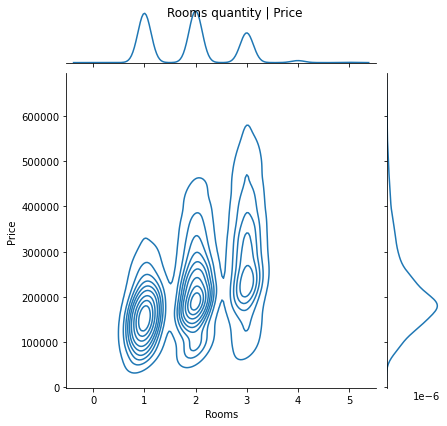

In [17]:
rooms_price = sns.jointplot(train_df['Rooms'], train_df['Price'], kind='kde')
rooms_price.fig.set_figwidth(6)
rooms_price.fig.set_figheight(6)

plt.xlabel("Rooms quantity")
plt.ylabel("Price")
plt.suptitle('Rooms quantity | Price')

plt.show()

Тут видна простая зависимость, чем больлше комнат - тем больше цена в большинстве случаев.

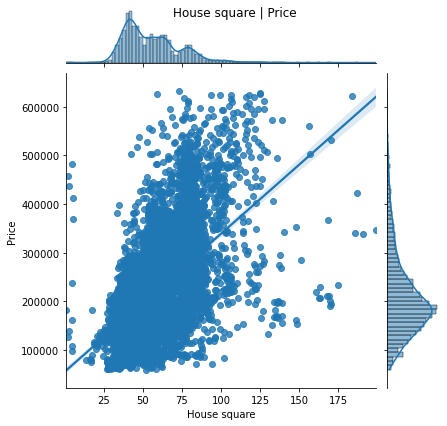

In [18]:
square_price = sns.jointplot(train_df['Square'], train_df['Price'], kind='reg')
square_price.fig.set_figwidth(6)
square_price.fig.set_figheight(6)

plt.xlabel("House square")
plt.ylabel("Price")
plt.suptitle('House square | Price')

plt.show()

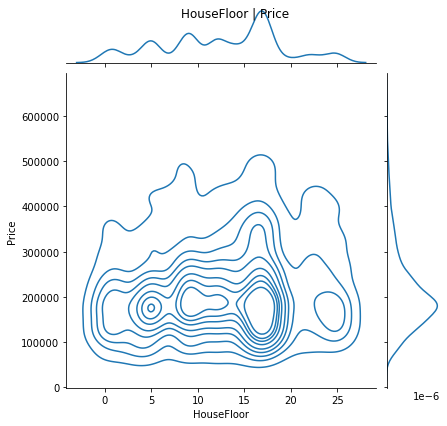

In [19]:
housefloor_price = sns.jointplot(train_df['HouseFloor'], train_df['Price'], kind='kde')
housefloor_price.fig.set_figwidth(6)
housefloor_price.fig.set_figheight(6)

plt.xlabel("Max floors in a house")
plt.ylabel("Price")
plt.suptitle('HouseFloor | Price')

plt.show()

Проверял, вдруг этажность дома влияет на цену (по типу, в новых домах больше этажей = это более новая недвижимость = чуть бОльшая цена). Но нет, видимо в регионе, откуда датасет взят на протяжении долгих лет стоятся дома +- одной этажности и на цену это почти не влияет

p.s. использовал разные параметры kind в seaborn, чтобы чуть меньше лагали графики с 10к точек)))

In [20]:
train_df.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

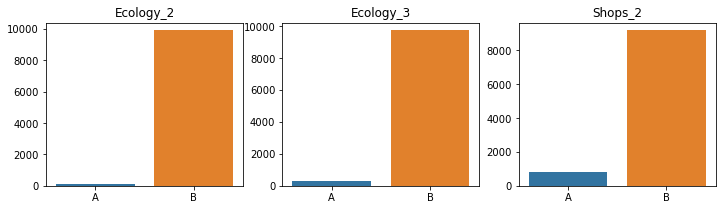

In [21]:
plt.figure(figsize=(12, 3))

plt.subplot(131)
ecology_2 = train_df['Ecology_2'].value_counts()
sns.barplot(ecology_2.index, ecology_2.values)
plt.title('Ecology_2')

plt.subplot(132)
ecology_3 = train_df['Ecology_3'].value_counts()
sns.barplot(ecology_3.index, ecology_3.values)
plt.title('Ecology_3')

plt.subplot(133)
shops_2 = train_df['Shops_2'].value_counts()
sns.barplot(shops_2.index, shops_2.values)
plt.title('Shops_2')

plt.show()

In [22]:
# перевожу категориальные признаки в численные
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

#### Тут мне захотелось вывести график, на котором ренж цены будет от 100000 до 370000, так как данных с остальными ценами мало

Для этого я создаю "adjusted" <code>Series</code>'ы к двум параметрам

In [23]:
price_adj1 = train_df[train_df['Price'].between(100000, 370000)]
price_adj = price_adj1['Price']
ecology_2_adj = train_df.loc[train_df['Price'].between(100000, 370000), 'Ecology_2']
type(price_adj), type(ecology_2_adj)

(pandas.core.series.Series, pandas.core.series.Series)

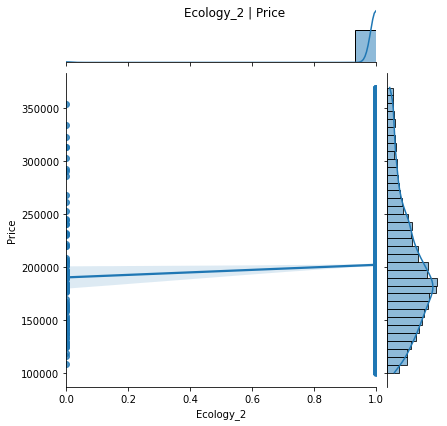

In [24]:
ecology2_price = sns.jointplot(ecology_2_adj, price_adj, kind='reg')
ecology2_price.fig.set_figwidth(6)
ecology2_price.fig.set_figheight(6)

plt.xlabel("Ecology_2")
plt.ylabel("Price")
plt.suptitle('Ecology_2 | Price')

plt.show()

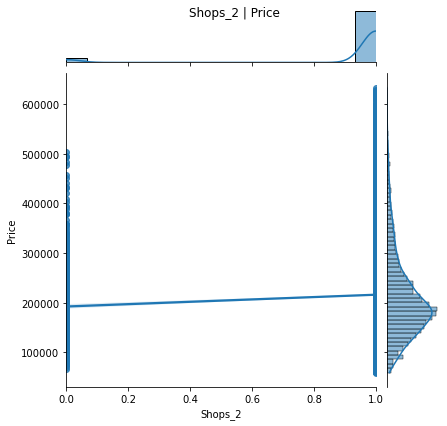

In [25]:
shops2_price = sns.jointplot(train_df['Shops_2'], train_df['Price'], kind='reg')
district_price.fig.set_figwidth(6)
district_price.fig.set_figheight(6)

plt.xlabel("Shops_2")
plt.ylabel("Price")
plt.suptitle('Shops_2 | Price')

plt.show()

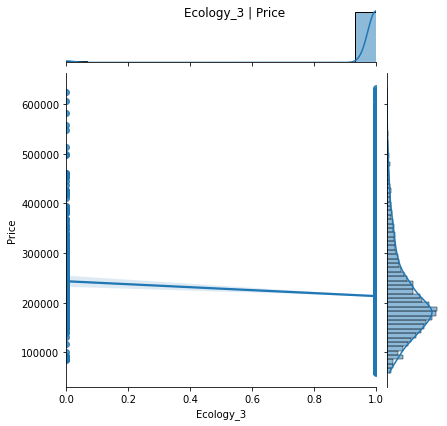

In [26]:
ecology3_price = sns.jointplot(train_df['Ecology_3'], train_df['Price'], kind='reg')
district_price.fig.set_figwidth(6)
district_price.fig.set_figheight(6)

plt.xlabel("Ecology_3")
plt.ylabel("Price")
plt.suptitle('Ecology_3 | Price')

plt.show()

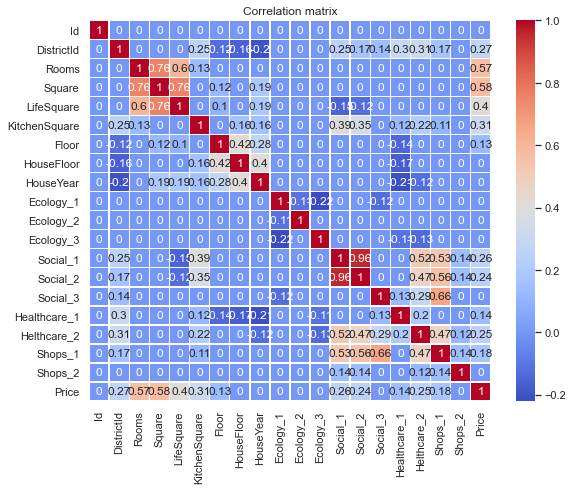

In [27]:
plt.figure(figsize = (9,7))

sns.set(font_scale=1.0)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.1] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

# Шаг 3. Обработка пропусков

In [28]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [29]:
(train_df['LifeSquare'] / train_df['Square'] * 100).mean()

65.28069305419922

Получается, жил. площадь в среднем равняется 65-и процентам от общей площади квартиры. Так что можно заменить пропущенные значения на значения общей площади умноженные на 0.65. Это должно быть точнее, чем заменять все НаНы на среднее значение

In [30]:
train_df['LifeSquare'].loc[train_df['LifeSquare'].isna()] = train_df.loc[train_df['LifeSquare'].isna()]['Square'] * 0.65

Оставлять колонку Healthcare_1 не вижу смысла, так как там пропущена половина данных

In [31]:
train_df.drop(['Healthcare_1'], axis=1, inplace=True)

In [32]:
train_df.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

## Формируем все изменения сверху в один класс

In [33]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
    
    def transform(self, X):
        """Трансформация данных"""
        
        # обрабатываем выбросы
        X['HouseYear'].loc[X['HouseYear'] > 2020] = X['HouseYear'].median()
        X['LifeSquare'].loc[X['LifeSquare'] > 200] = X['LifeSquare'].median()
        X['KitchenSquare'].loc[X['KitchenSquare'] > 20] = X['KitchenSquare'].median()
        X['Rooms'].loc[X['Rooms'] > 5] = X['Rooms'].median()
        X['HouseFloor'].loc[X['HouseFloor'] > 25] = X['HouseFloor'].median()
        X['Square'].loc[X['Square'] > 200] = X['Square'].median()
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare'].loc[X['LifeSquare'].isna()] = X.loc[X['LifeSquare'].isna()]['Square'] * 0.65
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

# Шаг 4. Построение новых фичей

Взял эти 4 фичи из ноутбука-примера

### DistrictSize

In [35]:
district_size = train_df['DistrictId'].value_counts().reset_index().\
                                       rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

In [36]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')

train_df['DistrictSize'].head()

0     22
1     87
2    174
3    179
4     97
Name: DistrictSize, dtype: int64

### IsDistrictLarge

In [37]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [38]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

train_df['IsDistrictLarge'].head()

0    0
1    0
2    1
3    1
4    0
Name: IsDistrictLarge, dtype: int32

### MedPriceByDistrict

In [39]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                        .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.437500
1,0,2.0,176210.812500
2,0,3.0,300610.375000
3,1,1.0,146735.671875
4,1,2.0,202666.312500


### MedPriceByFloorYear

In [40]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [41]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins)

0        (5, 9]
1        (5, 9]
2        (5, 9]
3        (5, 9]
4       (9, 15]
         ...   
9995     (5, 9]
9996    (9, 15]
9997    (9, 15]
9998     (0, 3]
9999     (5, 9]
Name: Floor, Length: 10000, dtype: category
Categories (5, interval[int64]): [(0, 3] < (3, 5] < (5, 9] < (9, 15] < (15, 42]]

In [42]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,year_cat,floor_cat
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,...,7976,5,0,11,1,184966.937500,22,0,3,3
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,...,10309,1,1,16,1,300009.437500,87,0,3,3
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,...,7759,0,1,3,1,220925.906250,174,1,3,3
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,...,5735,3,0,5,1,175616.234375,179,1,3,3
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,...,5776,1,2,4,1,150226.531250,97,0,3,4


In [43]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,380359.12500
1,1,2,321497.43750
2,1,3,368718.25000
3,1,4,400715.43750
4,2,1,467230.53125


In [44]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,year_cat,floor_cat,MedPriceByFloorYear
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,...,5,0,11,1,184966.937500,22,0,3,3,188121.296875
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,...,1,1,16,1,300009.437500,87,0,3,3,188121.296875
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,...,0,1,3,1,220925.906250,174,1,3,3,188121.296875
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,...,3,0,5,1,175616.234375,179,1,3,3,188121.296875
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,...,1,2,4,1,150226.531250,97,0,3,4,185190.984375


### Теперь создаем класс, который создаст новые фичи

In [45]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

In [46]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'DistrictSize',
 'IsDistrictLarge',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']

In [54]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['DistrictSize', 'new_district', 'IsDistrictLarge',  'MedPriceByDistrict', 'MedPriceByFloorYear']


target_name = 'Price'

# Шаг 5. Построение моделей

In [49]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [50]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [51]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 18), (3300, 18), (5000, 18))

In [52]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 25), (3300, 25), (5000, 25))

In [55]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [56]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

In [57]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=21)

# Шаг 6. Настройка и оценка финальной модели

In [ ]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Train R2:	0.966
Test R2:	0.705


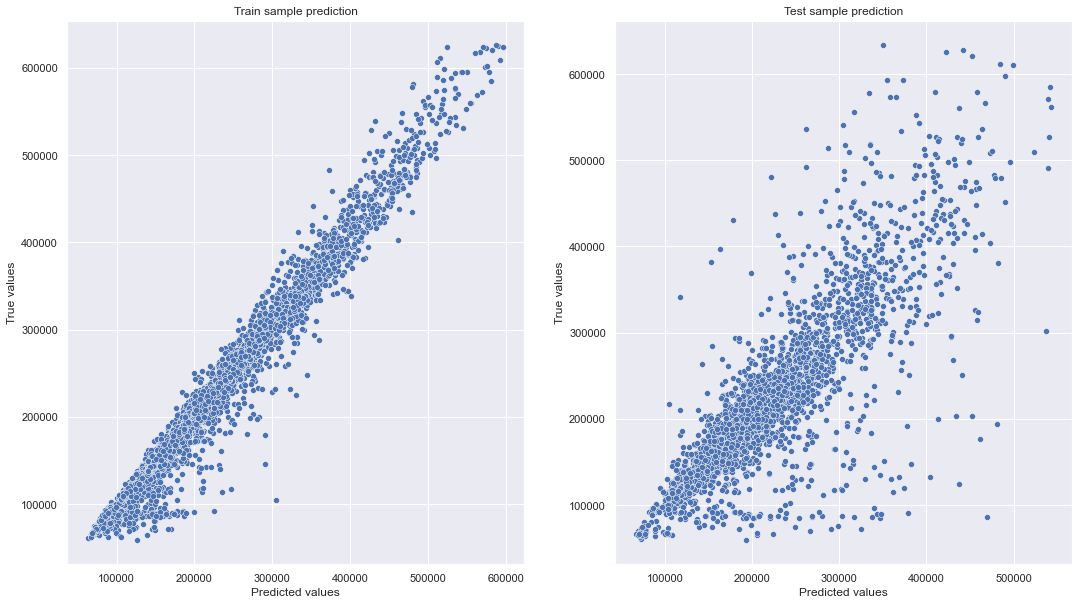

In [60]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [61]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.73514466, 0.74338534, 0.76373572])

In [62]:
cv_score.mean()

0.7474219062413874

# Шаг 7. Анализ прогнозов

In [63]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
19,MedPriceByDistrict,0.629933
1,Square,0.117661
16,DistrictSize,0.028645
2,LifeSquare,0.028046
3,KitchenSquare,0.024656
6,HouseYear,0.024053
4,Floor,0.023375
12,Social_3,0.020667
20,MedPriceByFloorYear,0.020143
5,HouseFloor,0.016781


In [64]:
test_df.shape

(5000, 21)

# Шаг 8. Сохранение модели

In [65]:
submit = pd.read_csv(SAMPLES_PATH)
submit.head()

,Id,Price
0,725,200000.0
1,15856,200000.0
2,5480,200000.0
3,15664,200000.0
4,14275,200000.0


In [66]:
predictions = rf_model.predict(test_df)
predictions

array([147124.92549999, 214953.9894326 , 233552.697024  , ...,
       330263.80233165, 201018.71589036, 158904.00829288])

In [67]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,725,147124.925500
1,15856,214953.989433
2,5480,233552.697024
3,15664,320413.502600
4,14275,145509.450918


In [68]:
submit.to_csv('rf_submit.csv', index=False)

Sergey Maksymchuk - ник на Kaggle

0.67266 - скор в лидерборде

Странно почему так, в ноутбуке вроде как меньше чем 0.705 не выдает. Еще доработаю модель, может поднимется скор)